Using device: mps


/Users/ashishlama/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = -948.6882943145046
New best model saved with reward: -948.6882943145046
Episode 2: Total Reward = -559.2769230769595
New best model saved with reward: -559.2769230769595
Episode 3: Total Reward = -703.4814332248387
Episode 4: Total Reward = -46.34827586206862
New best model saved with reward: -46.34827586206862
Episode 5: Total Reward = -124.6411764705889
Episode 6: Total Reward = -259.1919413919371
Episode 7: Total Reward = -608.4353383459534
Episode 8: Total Reward = -14.179381443297117
New best model saved with reward: -14.179381443297117
Episode 9: Total Reward = -349.94550898202635
Episode 10: Total Reward = -277.19966555183373
Episode 11: Total Reward = -1621.4602836874992
Episode 12: Total Reward = -151.92439024390333
Episode 13: Total Reward = -1727.3558922555178
Episode 14: Total Reward = -23.298327759196553
Episode 15: Total Reward = -1606.1568627447753
Episode 16: Total Reward = -510.01556886230117
Episode 17: Total Reward = -345.5820512820412
Episo

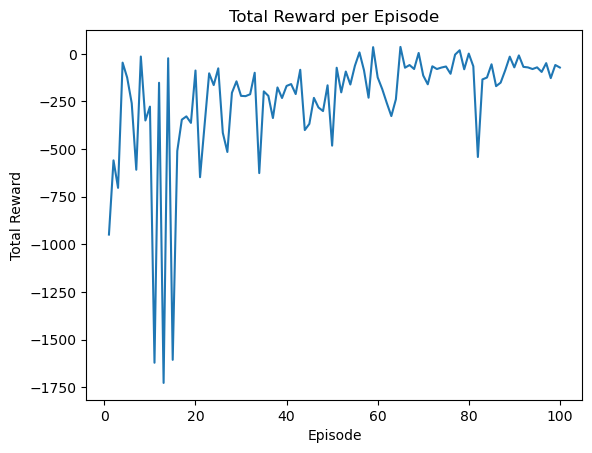

<All keys matched successfully>

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo

# Check if MPS is available and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_actions):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_actions)

    def forward(self, x):
        return self.resnet(x)

# Initialize the Gym environment with render_mode and continuous=False
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
num_actions = env.action_space.n  # Discrete action space

# Initialize the model, loss function, and optimizer
model = ResNetModel(num_actions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00023)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

buffer_capacity = 10000
batch_size = 64
replay_buffer = ReplayBuffer(buffer_capacity)

# Epsilon-Greedy Policy
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500

def get_epsilon(steps_done):
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)

# Function to preprocess the observation
def preprocess_observation(obs):
    if isinstance(obs, tuple):
        obs = obs[0]  # Unpack the observation if it's a tuple
    if len(obs.shape) == 3:  # Check if the observation is an image
        obs = np.transpose(obs, (2, 0, 1))  # Change to (C, H, W) format
        obs = torch.tensor(obs, dtype=torch.float32) / 255.0  # Normalize
        return obs.unsqueeze(0).to(device)  # Add batch dimension and move to device
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Handle non-image observations

# Function to select an action
def select_action(state, steps_done):
    epsilon = get_epsilon(steps_done)
    if random.random() > epsilon:
        with torch.no_grad():
            action_probs = model(state).cpu().numpy().squeeze()
        return np.argmax(action_probs)
    else:
        return random.randrange(num_actions)

# Training function
def train():
    if len(replay_buffer) < batch_size:
        return
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states = torch.cat(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.cat(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * next_q_values * 0.99

    loss = criterion(current_q_values, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
num_episodes = 100
steps_done = 0
reward_history = []
best_reward = -float('inf')

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        env.render()
        state = preprocess_observation(obs)
        action = select_action(state, steps_done)
        next_obs, reward, done, truncated, info = env.step(action)
        next_state = preprocess_observation(next_obs)
        
        replay_buffer.add((state, action, reward, next_state, done))
        obs = next_obs
        total_reward += reward
        steps_done += 1

        train()

    reward_history.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # Save the best model
    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(model.state_dict(), 'best_model_resnet.pt')
        print(f"New best model saved with reward: {best_reward}")

env.close()

# Plot and save reward history
plt.plot(range(1, num_episodes + 1), reward_history)
plt.xlabel('Step')
plt.ylabel('AvgReturn')
plt.title('Total Reward per Step')
plt.savefig('reward_history.pdf')
plt.show()  # Ensure the plot is displayed

# Load the best model
model.load_state_dict(torch.load('best_model_resnet.pt'))

Using device: mps
Step 10000: Average Return = -53.98008660580672
New best model saved with average return: -53.98008660580672
Step 20000: Average Return = -50.09286868707533
New best model saved with average return: -50.09286868707533


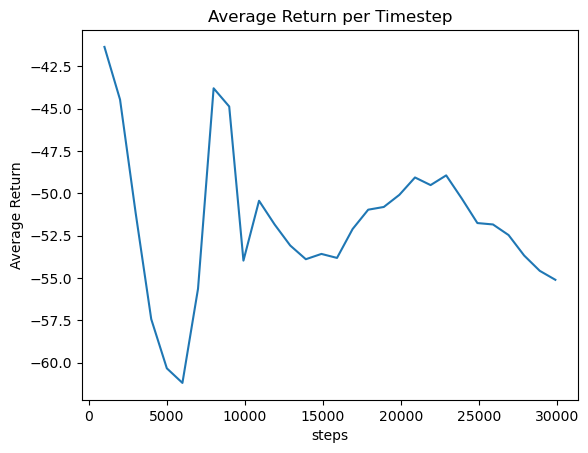

<All keys matched successfully>

In [6]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_actions):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_actions)

    def forward(self, x):
        return self.resnet(x)

# Initialize the Gym environment with render_mode and continuous=False
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
num_actions = env.action_space.n  # Discrete action space

# Initialize the model, loss function, and optimizer
model = ResNetModel(num_actions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)  # Updated learning rate

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

buffer_capacity = 10000  # Updated buffer size
batch_size = 32  # Updated batch size
replay_buffer = ReplayBuffer(buffer_capacity)

# Epsilon-Greedy Policy
epsilon_start = 1.0
epsilon_min = 0.1
epsilon_decay = 500
gamma = 0.99  # Updated gamma

def get_epsilon(steps_done):
    return max(epsilon_min, epsilon_start - steps_done / epsilon_decay)

# Function to preprocess the observation
def preprocess_observation(obs):
    if isinstance(obs, tuple):
        obs = obs[0]  # Unpack the observation if it's a tuple
    if len(obs.shape) == 3:  # Check if the observation is an image
        obs = np.transpose(obs, (2, 0, 1))  # Change to (C, H, W) format
        obs = torch.tensor(obs, dtype=torch.float32) / 255.0  # Normalize
        return obs.unsqueeze(0).to(device)  # Add batch dimension and move to device
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Handle non-image observations

# Function to select an action
def select_action(state, steps_done):
    epsilon = get_epsilon(steps_done)
    if random.random() > epsilon:
        with torch.no_grad():
            action_probs = model(state).cpu().numpy().squeeze()
        return np.argmax(action_probs)
    else:
        return random.randrange(num_actions)

# Training function
def train():
    if len(replay_buffer) < batch_size or steps_done < warmup_steps:
        return
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states = torch.cat(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.cat(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * next_q_values * gamma

    loss = criterion(current_q_values, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize the target network
target_model = ResNetModel(num_actions).to(device)
target_model.load_state_dict(model.state_dict())

# Training loop with timesteps and target network update
max_steps = 30000  # Updated max steps
timestep_interval = 10000  # Interval to report progress and save model
warmup_steps = 5000  # Updated warmup steps
target_update_interval = 1000  # Updated target network update interval
steps_done = 0
reward_history = []
timesteps = []  # List to keep track of timesteps for reward recording
best_reward = -float('inf')
total_reward = 0

obs = env.reset()
done = False

for t in range(max_steps):
    env.render()
    state = preprocess_observation(obs)
    action = select_action(state, steps_done)
    next_obs, reward, done, truncated, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    
    replay_buffer.add((state, action, reward, next_state, done))
    obs = next_obs
    total_reward += reward
    steps_done += 1

    train()

    if steps_done % target_update_interval == 0:
        target_model.load_state_dict(model.state_dict())

    if done or truncated:
        obs = env.reset()
        reward_history.append(total_reward)
        timesteps.append(steps_done)  # Record the current timestep
        total_reward = 0
        done = False

    # Save model and print progress every timestep_interval timesteps
    if t % timestep_interval == 0 and t > 0:
        avg_return = np.mean(reward_history[-timestep_interval:])
        print(f"Step {t}: Average Return = {avg_return}")
        if avg_return > best_reward:
            best_reward = avg_return
            torch.save(model.state_dict(), 'best_model_resnet.pt')
            print(f"New best model saved with average return: {best_reward}")

env.close()

# Plot and save reward history
avg_reward_history = [np.mean(reward_history[max(0, i-timestep_interval):i+1]) for i in range(len(reward_history))]
plt.plot(timesteps, avg_reward_history)  # Use timesteps for x-axis
plt.xlabel('steps')
plt.ylabel('Average Return')
plt.title('Average Return per Timestep')
plt.savefig('reward_history_timesteps.pdf')
plt.show()  # Ensure the plot is displayed

# Load the best model
model.load_state_dict(torch.load('best_model_resnet.pt'))

In [7]:
np.mean(reward_history[-timestep_interval:])

13.611553276818228

Using device: mps
Step 10000: Average Return = -69.92938188194906
New best model saved with average return: -69.92938188194906
Step 20000: Average Return = -61.70700799453226
New best model saved with average return: -61.70700799453226
Step 30000: Average Return = -60.33082320627582
New best model saved with average return: -60.33082320627582
Step 40000: Average Return = -57.80513928193892
New best model saved with average return: -57.80513928193892
Step 50000: Average Return = -57.106951571464734
New best model saved with average return: -57.106951571464734
Step 60000: Average Return = -52.45178066094702
New best model saved with average return: -52.45178066094702
Step 70000: Average Return = -51.675500160061446
New best model saved with average return: -51.675500160061446
Step 80000: Average Return = -50.681647422326236
New best model saved with average return: -50.681647422326236
Step 90000: Average Return = -50.859177384466086
Step 100000: Average Return = -49.00196267690038
New be

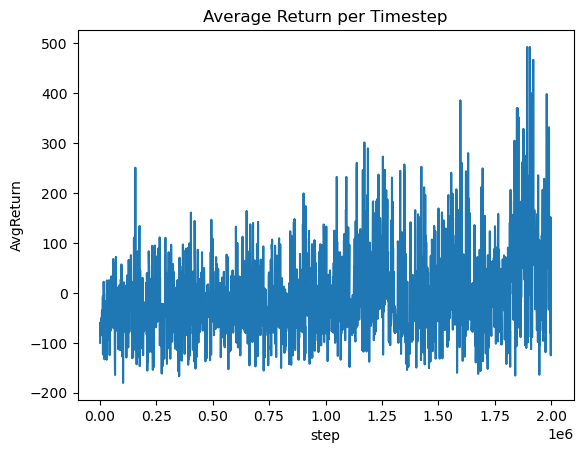

<All keys matched successfully>

In [5]:
np.mean(reward_history[-timestep_interval:])

-6.3569783082754165

Using device: mps


/Users/ashishlama/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Step 10000: Average Return = -53.66655310284919
New best model saved with average return: -53.66655310284919
Step 20000: Average Return = -48.400600323308886
New best model saved with average return: -48.400600323308886
Step 30000: Average Return = -48.95799566543943
Step 40000: Average Return = -52.12304174456727
Step 50000: Average Return = -53.34708939224588
Step 60000: Average Return = -52.91138965322129
Step 70000: Average Return = -56.1789320905156
Step 80000: Average Return = -55.15641229417978
Step 90000: Average Return = -53.579222403108815
Step 100000: Average Return = -51.3466927079835
Step 110000: Average Return = -51.164229639574074
Step 120000: Average Return = -50.473475433608044
Step 130000: Average Return = -53.55870420261201
Step 140000: Average Return = -52.03377331704421
Step 150000: Average Return = -50.53026177474238
Step 160000: Average Return = -49.56084095603165
Step 170000: Average Return = -49.470783844020936
Step 180000: Average Return = -49.094114872592634


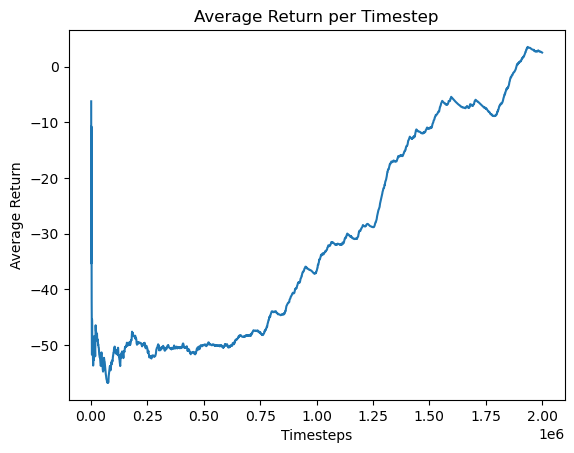

<All keys matched successfully>

In [7]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_actions):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_actions)

    def forward(self, x):
        return self.resnet(x)

# Initialize the Gym environment with render_mode and continuous=False
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
num_actions = env.action_space.n  # Discrete action space

# Initialize the model, loss function, and optimizer
model = ResNetModel(num_actions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)  # Updated learning rate

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

buffer_capacity = 10000  # Updated buffer size
batch_size = 32  # Updated batch size
replay_buffer = ReplayBuffer(buffer_capacity)

# Epsilon-Greedy Policy
epsilon_start = 1.0
epsilon_min = 0.1
epsilon_decay = 500
gamma = 0.99  # Updated gamma

def get_epsilon(steps_done):
    return max(epsilon_min, epsilon_start - steps_done / epsilon_decay)

# Function to preprocess the observation
def preprocess_observation(obs):
    if isinstance(obs, tuple):
        obs = obs[0]  # Unpack the observation if it's a tuple
    if len(obs.shape) == 3:  # Check if the observation is an image
        obs = np.transpose(obs, (2, 0, 1))  # Change to (C, H, W) format
        obs = torch.tensor(obs, dtype=torch.float32) / 255.0  # Normalize
        return obs.unsqueeze(0).to(device)  # Add batch dimension and move to device
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Handle non-image observations

# Function to select an action
def select_action(state, steps_done):
    epsilon = get_epsilon(steps_done)
    if random.random() > epsilon:
        with torch.no_grad():
            action_probs = model(state).cpu().numpy().squeeze()
        return np.argmax(action_probs)
    else:
        return random.randrange(num_actions)

# Training function
def train():
    if len(replay_buffer) < batch_size or steps_done < warmup_steps:
        return
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states = torch.cat(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.cat(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * next_q_values * gamma

    loss = criterion(current_q_values, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize the target network
target_model = ResNetModel(num_actions).to(device)
target_model.load_state_dict(model.state_dict())

# Training loop with timesteps and target network update
max_steps = int(2e6)  # Updated max steps
timestep_interval = 10000  # Interval to report progress and save model
warmup_steps = 5000  # Updated warmup steps
target_update_interval = 1000  # Updated target network update interval
steps_done = 0
reward_history = []
timesteps = []  # List to keep track of timesteps for reward recording
best_reward = -float('inf')
total_reward = 0

obs = env.reset()
done = False

for t in range(max_steps):
    env.render()
    state = preprocess_observation(obs)
    action = select_action(state, steps_done)
    next_obs, reward, done, truncated, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    
    replay_buffer.add((state, action, reward, next_state, done))
    obs = next_obs
    total_reward += reward
    steps_done += 1

    train()

    if steps_done % target_update_interval == 0:
        target_model.load_state_dict(model.state_dict())

    if done or truncated:
        obs = env.reset()
        reward_history.append(total_reward)
        timesteps.append(steps_done)  # Record the current timestep
        total_reward = 0
        done = False

    # Save model and print progress every timestep_interval timesteps
    if t % timestep_interval == 0 and t > 0:
        avg_return = np.mean(reward_history[-timestep_interval:])
        print(f"Step {t}: Average Return = {avg_return}")
        if avg_return > best_reward:
            best_reward = avg_return
            torch.save(model.state_dict(), 'best_model_resnet.pt')
            print(f"New best model saved with average return: {best_reward}")

env.close()

# Plot and save reward history
avg_reward_history = [np.mean(reward_history[max(0, i-timestep_interval):i+1]) for i in range(len(reward_history))]
plt.plot(timesteps, avg_reward_history)  # Use timesteps for x-axis
plt.xlabel('Timesteps')
plt.ylabel('Average Return')
plt.title('Average Return per Timestep')
plt.savefig('reward_history_timesteps.pdf')
plt.show()  # Ensure the plot is displayed

# Load the best model
model.load_state_dict(torch.load('best_model_resnet.pt'))

Using device: mps
Using device: mps


/Users/ashishlama/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Step 10000: Average Return = -64.63349617310037
New best model saved with average return: -64.63349617310037
Step 20000: Average Return = -60.33772881901266
New best model saved with average return: -60.33772881901266
Step 30000: Average Return = -56.82364780014504
New best model saved with average return: -56.82364780014504
Step 40000: Average Return = -53.9548706449969
New best model saved with average return: -53.9548706449969
Step 50000: Average Return = -58.26231735965758
Step 60000: Average Return = -58.36790337620151
Step 70000: Average Return = -59.78282503142886
Step 80000: Average Return = -60.625012116995634
Step 90000: Average Return = -59.8340650854171
Step 100000: Average Return = -60.52140459326482
Step 110000: Average Return = -61.2681614608071
Step 120000: Average Return = -58.69409583723706
Step 130000: Average Return = -58.543203145850626
Step 140000: Average Return = -57.76308434535618
Step 150000: Average Return = -58.51357473215547
Step 160000: Average Return = -5

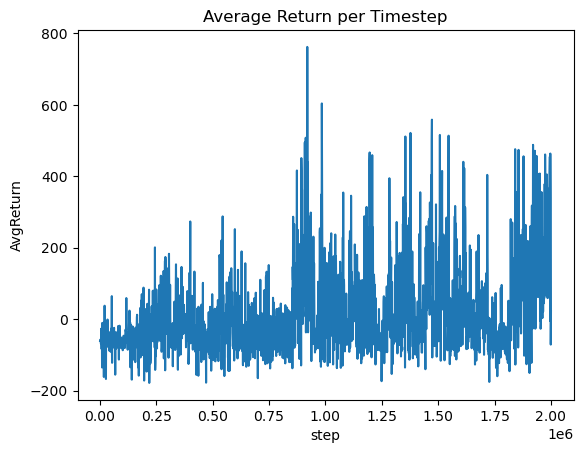

/Users/ashishlama/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ashishlama/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Step 10000: Average Return = nan
Step 20000: Average Return = nan
Step 30000: Average Return = nan
Step 40000: Average Return = nan
Step 50000: Average Return = nan
Step 60000: Average Return = nan
Step 70000: Average Return = nan
Step 80000: Average Return = nan
Step 90000: Average Return = nan
Step 100000: Average Return = nan
Step 110000: Average Return = nan
Step 120000: Average Return = nan
Step 130000: Average Return = nan
Step 140000: Average Return = nan
Step 150000: Average Return = nan
Step 160000: Average Return = nan
Step 170000: Average Return = nan
Step 180000: Average Return = nan
Step 190000: Average Return = nan
Step 200000: Average Return = nan
Step 210000: Average Return = nan
Step 220000: Average Return = nan
Step 230000: Average Return = nan
Step 240000: Average Return = nan
Step 250000: Average Return = nan
Step 260000: Average Return = nan
Step 270000: Average Return = nan
Step 280000: Average Return = nan
Step 290000: Average Return = nan
Step 300000: Average Re

In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_actions):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_actions)

    def forward(self, x):
        return self.resnet(x)

# Initialize the Gym environment with render_mode and continuous=False
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
num_actions = env.action_space.n  # Discrete action space

# Initialize the model, loss function, and optimizer
model = ResNetModel(num_actions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)  # Updated learning rate

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

buffer_capacity = 10000  # Updated buffer size
batch_size = 32  # Updated batch size
replay_buffer = ReplayBuffer(buffer_capacity)

# Epsilon-Greedy Policy
epsilon_start = 1.0
epsilon_min = 0.1
epsilon_decay = 500
gamma = 0.99  # Updated gamma

def get_epsilon(steps_done):
    return max(epsilon_min, epsilon_start - steps_done / epsilon_decay)

# Function to preprocess the observation
def preprocess_observation(obs):
    if isinstance(obs, tuple):
        obs = obs[0]  # Unpack the observation if it's a tuple
    if len(obs.shape) == 3:  # Check if the observation is an image
        obs = np.transpose(obs, (2, 0, 1))  # Change to (C, H, W) format
        obs = torch.tensor(obs, dtype=torch.float32) / 255.0  # Normalize
        return obs.unsqueeze(0).to(device)  # Add batch dimension and move to device
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Handle non-image observations

# Function to select an action
def select_action(state, steps_done):
    epsilon = get_epsilon(steps_done)
    if random.random() > epsilon:
        with torch.no_grad():
            action_probs = model(state).cpu().numpy().squeeze()
        return np.argmax(action_probs)
    else:
        return random.randrange(num_actions)

# Training function
def train():
    if len(replay_buffer) < batch_size or steps_done < warmup_steps:
        return
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states = torch.cat(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.cat(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * next_q_values * gamma

    loss = criterion(current_q_values, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize the target network
target_model = ResNetModel(num_actions).to(device)
target_model.load_state_dict(model.state_dict())

# Training loop with timesteps and target network update
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_actions):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_actions)

    def forward(self, x):
        return self.resnet(x)

# Initialize the Gym environment with render_mode and continuous=False
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
num_actions = env.action_space.n  # Discrete action space

# Initialize the model, loss function, and optimizer
model = ResNetModel(num_actions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)  # Updated learning rate

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

buffer_capacity = 10000  # Updated buffer size
batch_size = 32  # Updated batch size
replay_buffer = ReplayBuffer(buffer_capacity)

# Epsilon-Greedy Policy
epsilon_start = 1.0
epsilon_min = 0.1
epsilon_decay = 500
gamma = 0.99  # Updated gamma

def get_epsilon(steps_done):
    return max(epsilon_min, epsilon_start - steps_done / epsilon_decay)

# Function to preprocess the observation
def preprocess_observation(obs):
    if isinstance(obs, tuple):
        obs = obs[0]  # Unpack the observation if it's a tuple
    if len(obs.shape) == 3:  # Check if the observation is an image
        obs = np.transpose(obs, (2, 0, 1))  # Change to (C, H, W) format
        obs = torch.tensor(obs, dtype=torch.float32) / 255.0  # Normalize
        return obs.unsqueeze(0).to(device)  # Add batch dimension and move to device
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Handle non-image observations

# Function to select an action
def select_action(state, steps_done):
    epsilon = get_epsilon(steps_done)
    if random.random() > epsilon:
        with torch.no_grad():
            action_probs = model(state).cpu().numpy().squeeze()
        return np.argmax(action_probs)
    else:
        return random.randrange(num_actions)

# Training function
def train():
    if len(replay_buffer) < batch_size or steps_done < warmup_steps:
        return
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states = torch.cat(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.cat(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * next_q_values * gamma

    loss = criterion(current_q_values, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize the target network
target_model = ResNetModel(num_actions).to(device)
target_model.load_state_dict(model.state_dict())

# Training loop with timesteps and target network update
max_steps = int(2e6)  # Updated max steps
timestep_interval = 10000  # Interval to report progress and save model
warmup_steps = 5000  # Updated warmup steps
target_update_interval = 10000  # Updated target network update interval
steps_done = 0
reward_history = []
timesteps = []  # List to keep track of timesteps for reward recording
best_reward = -float('inf')
total_reward = 0

obs = env.reset()
done = False

for t in range(max_steps):
    env.render()
    state = preprocess_observation(obs)
    action = select_action(state, steps_done)
    next_obs, reward, done, truncated, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    
    replay_buffer.add((state, action, reward, next_state, done))
    obs = next_obs
    total_reward += reward
    steps_done += 1

    train()

    if steps_done % target_update_interval == 0:
        target_model.load_state_dict(model.state_dict())

    if done or truncated:
        obs = env.reset()
        reward_history.append(total_reward)
        timesteps.append(steps_done)  # Record the current timestep
        total_reward = 0
        done = False

    # Save model and print progress every timestep_interval timesteps
    if t % timestep_interval == 0 and t > 0:
        print(f"Step {t}: Average Return = {np.mean(reward_history[-timestep_interval:])}")
        if np.mean(reward_history[-timestep_interval:]) > best_reward:
            best_reward = np.mean(reward_history[-timestep_interval:])
            torch.save(model.state_dict(), 'best_model_resnet.pt')
            print(f"New best model saved with average return: {best_reward}")

env.close()

# Plot and save reward history
plt.plot(timesteps, reward_history)  # Use timesteps for x-axis
plt.xlabel('step')
plt.ylabel('AvgReturn')
plt.title('Average Return per Timestep')
plt.savefig('reward_history_timesteps.pdf')
plt.show()  # Ensure the plot is displayed

# Load the best model
model.load_state_dict(torch.load('best_model_resnet.pt'))
  # Updated target network update interval
steps_done = 0
reward_history = []
timesteps = []  # List to keep track of timesteps for reward recording
best_reward = -float('inf')
total_reward = 0

obs = env.reset()
done = False

for t in range(max_steps):
    env.render()
    state = preprocess_observation(obs)
    action = select_action(state, steps_done)
    next_obs, reward, done, truncated, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    
    replay_buffer.add((state, action, reward, next_state, done))
    obs = next_obs
    total_reward += reward
    steps_done += 1

    train()

    if steps_done % target_update_interval == 0:
        target_model.load_state_dict(model.state_dict())

    if done or truncated:
        obs = env.reset()
        reward_history.append(total_reward)
        timesteps.append(steps_done)  # Record the current timestep
        total_reward = 0
        done = False

    # Save model and print progress every timestep_interval timesteps
    if t % timestep_interval == 0 and t > 0:
        print(f"Step {t}: Average Return = {np.mean(reward_history[timestep_interval:])}")
        if np.mean(reward_history[timestep_interval:]) > best_reward:
            best_reward = np.mean(reward_history[timestep_interval:])
            torch.save(model.state_dict(), 'best_model_resnet.pt')
            print(f"New best model saved with average return: {best_reward}")

env.close()

# Plot and save reward history
plt.plot(timesteps, reward_history)  # Use timesteps for x-axis
plt.xlabel('step')
plt.ylabel('AvgReturn')
plt.title('Average Return per Timestep')
plt.savefig('reward_history_timesteps.pdf')
plt.show()  # Ensure the plot is displayed

# Load the best model
model.load_state_dict(torch.load('best_model_resnet.pt'))
